In [1]:
import cv2
import numpy as np
import os

In [2]:
def load_mnist_data(data_path):
    def load_images_from_folder(folder):
        images = []
        labels = []
        # Iterate through subfolders (each named by the digit label)
        for label_folder in os.listdir(folder):
            label_path = os.path.join(folder, label_folder)
            if os.path.isdir(label_path):
                # Label is the count of digits in the folder name (e.g., '123' → 3)
                label = len(label_folder) if label_folder != '0' else 0
                # Load all images in the subfolder
                for filename in os.listdir(label_path):
                    img_path = os.path.join(label_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
                    if img is not None:
                        images.append(img)
                        labels.append(label)
        return images, labels

    # Load data for train, val, and test splits
    train_images, train_labels = load_images_from_folder(os.path.join(data_path, 'train'))
    val_images, val_labels = load_images_from_folder(os.path.join(data_path, 'val'))
    test_images, test_labels = load_images_from_folder(os.path.join(data_path, 'test'))

    # Organize and return the data as a dictionary
    data = {
        'train': (train_images, train_labels),
        'val': (val_images, val_labels),
        'test': (test_images, test_labels)
    }
    return data

# Example usage
data_path = "../../data/interim/double_mnist"  # Replace with actual path
data = load_mnist_data(data_path)

print(f"Train: {len(data['train'][0])} images, {len(data['train'][1])} labels")
print(f"Val: {len(data['val'][0])} images, {len(data['val'][1])} labels")
print(f"Test: {len(data['test'][0])} images, {len(data['test'][1])} labels")


Train: 12600 images, 12600 labels
Val: 3000 images, 3000 labels
Test: 4600 images, 4600 labels


Train: 12600 images, 12600 labels
Test: 4600 images, 4600
Val: 3000 images, 3000
Batch of images: torch.Size([32, 1, 128, 128])
Batch of labels: tensor([3, 3, 3, 2, 2, 1, 2, 2, 2, 2, 1, 3, 2, 3, 1, 2, 3, 3, 3, 2, 2, 3, 1, 1,
        2, 1, 2, 2, 2, 2, 2, 2])


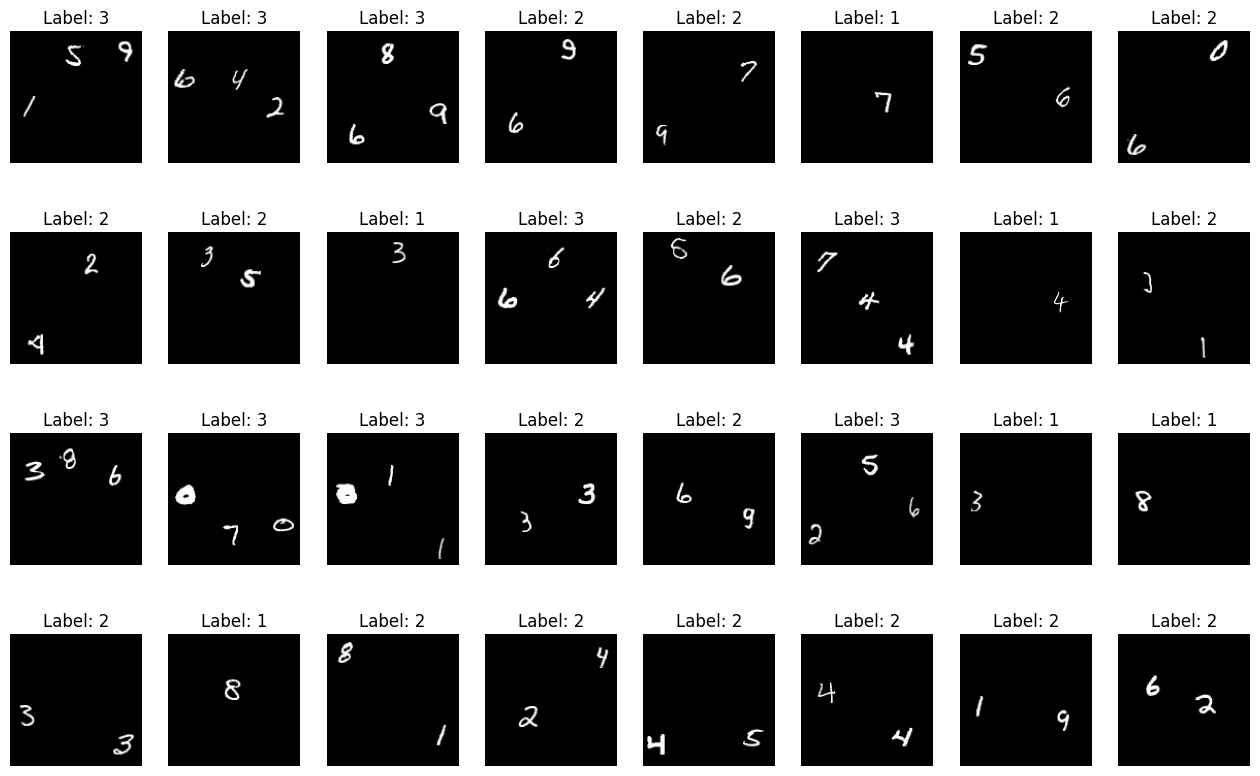

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class MultiMNISTDataset(Dataset):
    """
    Custom Dataset class for Multi-MNIST dataset. It takes in lists of images and labels
    and allows easy integration with PyTorch DataLoader.
    """
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (list of np.ndarray): List of images.
            labels (list of int): List of labels (digit counts).
            transform (callable, optional): Optional transform to be applied
                                            on an image sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.images)

    def __getitem__(self, idx):
        """Fetches a sample by index."""
        img = self.images[idx]
        label = self.labels[idx]

        # Convert image to torch tensor and normalize (if transform is not provided)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
            img = img.unsqueeze(0)  # Add channel dimension (1, H, W)

        label = torch.tensor(label, dtype=torch.long)
        return img, label

# Example usage
train_images, train_labels = data['train']
print(f"Train: {len(train_images)} images, {len(train_labels)} labels")
train_dataset = MultiMNISTDataset(train_images, train_labels)

test_images, test_labels = data['test']
print(f"Test: {len(test_images)} images, {len(test_labels)}")
test_dataset = MultiMNISTDataset(test_images, test_labels)

val_images, val_labels = data['val']
print(f"Val: {len(val_images)} images, {len(val_labels)}")
val_dataset = MultiMNISTDataset(val_images, val_labels)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check a batch
for imgs, labels in train_loader:
    print(f"Batch of images: {imgs.shape}")
    print(f"Batch of labels: {labels}")
    
    # Visualize all 32 images in the batch
    plt.figure(figsize=(16, 10))
    for i in range(32):
        img = imgs[i][0].numpy()
        label = labels[i].item()
        plt.subplot(4, 8, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()
    
    break

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DigitCountCNN(nn.Module):
    def __init__(self, num_classes=4, task='classification'):
        """
        Initialize CNN model that can perform either classification or regression
        
        Args:
            num_classes (int): Number of classes for classification
            task (str): Either 'classification' or 'regression'
        """
        super(DigitCountCNN, self).__init__()
        self.task = task.lower()
        if self.task not in ['classification', 'regression']:
            raise ValueError("Task must be either 'classification' or 'regression'")
        
        # Convolutional layers (same for both tasks)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128,128 , kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        
        # Output layer changes based on task
        if self.task == 'classification':
            self.fc2 = nn.Linear(256, num_classes)
        else:  # regression
            self.fc2 = nn.Linear(256, 1)  # Single continuous output
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        # x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Apply activation for classification (if needed)
        if self.task == 'classification':
            # Note: We don't apply softmax here because CrossEntropyLoss includes it
            return x
        else:
            # For regression, we might want to ensure non-negative outputs
            # depending on your specific use case
            return F.relu(x)  # or just return x if negative values are acceptable



In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def train_model(model, train_loader, valid_loader, device, num_epochs, learning_rate, dropout_rate, optimizer_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss() if model.task == 'classification' else nn.MSELoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_metrics = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'confusion_matrix': [],
        'mae': [], 'mse': [], 'r2': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            if model.task == 'regression':
                labels = labels.float().view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Store training loss for the epoch
        train_losses.append(running_loss / len(train_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}")

        # Validation
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            if model.task == 'classification':
                for images, labels in valid_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

                # Calculate metrics
                accuracy = accuracy_score(y_true, y_pred)
                precision = precision_score(y_true, y_pred, average='weighted')
                recall = recall_score(y_true, y_pred, average='weighted')
                f1 = f1_score(y_true, y_pred, average='weighted')
                conf_matrix = confusion_matrix(y_true, y_pred)

                val_metrics['accuracy'].append(accuracy)
                val_metrics['precision'].append(precision)
                val_metrics['recall'].append(recall)
                val_metrics['f1_score'].append(f1)
                val_metrics['confusion_matrix'].append(conf_matrix)

            else:
                val_loss = 0.0
                for images, labels in valid_loader:
                    images = images.to(device)
                    labels = labels.float().view(-1, 1).to(device)
                    outputs = model(images)
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(outputs.cpu().numpy())
                    val_loss += criterion(outputs, labels).item()
                
                val_metrics['mae'].append(mean_absolute_error(y_true, y_pred))
                val_metrics['mse'].append(mean_squared_error(y_true, y_pred))
                val_metrics['r2'].append(r2_score(y_true, y_pred))
                train_losses.append(val_loss / len(valid_loader))

    return train_losses, val_metrics


In [39]:
print(torch.cuda.is_available())

True


In [40]:
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the selected cases
hyperparam_cases = [
    {'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD'},
    {'learning_rate': 0.01, 'dropout_rate': 0.3, 'optimizer': 'Adam'},
    {'learning_rate': 0.05, 'dropout_rate': 0.5, 'optimizer': 'RMSprop'},
    {'learning_rate': 0.01, 'dropout_rate': 0.0, 'optimizer': 'SGD'},
    {'learning_rate': 0.001, 'dropout_rate': 0.5, 'optimizer': 'Adam'}
]

results = []

for case in hyperparam_cases:
    # Initialize model with current dropout rate
    model = DigitCountCNN(num_classes=4, task='classification')
    model.dropout = nn.Dropout(case['dropout_rate'])

    # save the models
    torch.save(model, f"./model_classification_{case}.pt")

    print(f"model number {case}")
    
    # Train model and gather metrics
    train_losses, val_metrics = train_model(
        model=model,
        train_loader=train_loader,
        valid_loader=val_loader,
        device=device,
        num_epochs=5,
        learning_rate=case['learning_rate'],
        dropout_rate=case['dropout_rate'],
        optimizer_name=case['optimizer']
    )
    
    results.append({
        'learning_rate': case['learning_rate'],
        'dropout_rate': case['dropout_rate'],
        'optimizer': case['optimizer'],
        'train_losses': train_losses,
        'val_metrics': val_metrics
    })
    print(f"model number {case} done")
    print("results",results)


Using device: cuda
model number {'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD'}
Epoch 1/5, Training Loss: 1.3273804529669322


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5, Training Loss: 1.1610677582660907


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5, Training Loss: 1.1235608207392813


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/5, Training Loss: 1.1080053516753434


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5, Training Loss: 1.0766031490969779


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model number {'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD'} done
results [{'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD', 'train_losses': [1.3273804529669322, 1.1610677582660907, 1.1235608207392813, 1.1080053516753434, 1.0766031490969779], 'val_metrics': {'accuracy': [0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333], 'precision': [np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444)], 'recall': [np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333)], 'f1_score': [np.float64(0.3710144927536232), np.float64(0.3710144927536232), np.float64(0.3710144927536232), np.float64(0.3710144927536232), np.float64(0.3710144927536232)], 'confusion_matrix': [array([[   0,    0,  100,    0],
       [   0,

/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5, Training Loss: 1.1440451547579111


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5, Training Loss: 1.1434943913505766


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/5, Training Loss: 1.1434957760239615


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5, Training Loss: 1.142952191950706


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model number {'learning_rate': 0.01, 'dropout_rate': 0.3, 'optimizer': 'Adam'} done
results [{'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD', 'train_losses': [1.3273804529669322, 1.1610677582660907, 1.1235608207392813, 1.1080053516753434, 1.0766031490969779], 'val_metrics': {'accuracy': [0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333], 'precision': [np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444)], 'recall': [np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333)], 'f1_score': [np.float64(0.3710144927536232), np.float64(0.3710144927536232), np.float64(0.3710144927536232), np.float64(0.3710144927536232), np.float64(0.3710144927536232)], 'confusion_matrix': [array([[   0,    0,  100,    0],
       [   0,

/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5, Training Loss: 1.4177834797026543


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/5, Training Loss: 1.1449642818288754


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5, Training Loss: 1.1448248918286434


/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model number {'learning_rate': 0.05, 'dropout_rate': 0.5, 'optimizer': 'RMSprop'} done
results [{'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD', 'train_losses': [1.3273804529669322, 1.1610677582660907, 1.1235608207392813, 1.1080053516753434, 1.0766031490969779], 'val_metrics': {'accuracy': [0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333], 'precision': [np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444)], 'recall': [np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333)], 'f1_score': [np.float64(0.3710144927536232), np.float64(0.3710144927536232), np.float64(0.3710144927536232), np.float64(0.3710144927536232), np.float64(0.3710144927536232)], 'confusion_matrix': [array([[   0,    0,  100,    0],
       [  

/home/pratyush/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5, Training Loss: 0.19018837575550157
Epoch 3/5, Training Loss: 0.008936721263370632
Epoch 4/5, Training Loss: 0.002599631793909886
Epoch 5/5, Training Loss: 0.0014876633861691923
model number {'learning_rate': 0.01, 'dropout_rate': 0.0, 'optimizer': 'SGD'} done
results [{'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD', 'train_losses': [1.3273804529669322, 1.1610677582660907, 1.1235608207392813, 1.1080053516753434, 1.0766031490969779], 'val_metrics': {'accuracy': [0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333], 'precision': [np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444), np.float64(0.28444444444444444)], 'recall': [np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333)], 'f1_score': [np.float64(0.3710144927536232), np.float6

In [25]:
# create a copy of the results
results_copy = results.copy()

for r in results_copy:
    em = []
    for i in r['val_metrics']['precision']:
        em.append(float(i))
    r['val_metrics']['precision'] = em

    em = []
    for i in r['val_metrics']['accuracy']:
        em.append(float(i))
    r['val_metrics']['accuracy'] = em

    em = []
    for i in r['val_metrics']['recall']:
        em.append(float(i))
    r['val_metrics']['recall'] = em

    em = []
    for i in r['val_metrics']['f1_score']:
        em.append(float(i))
    r['val_metrics']['f1_score'] = em

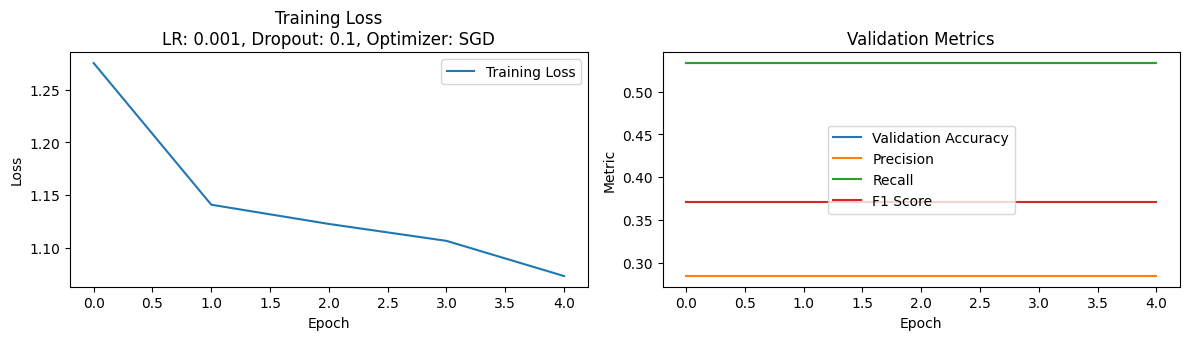

{'accuracy': [0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333], 'precision': [0.28444444444444444, 0.28444444444444444, 0.28444444444444444, 0.28444444444444444, 0.28444444444444444], 'recall': [0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333], 'f1_score': [0.3710144927536232, 0.3710144927536232, 0.3710144927536232, 0.3710144927536232, 0.3710144927536232], 'confusion_matrix': [array([[   0,    0,  100,    0],
       [   0,    0,  500,    0],
       [   0,    0, 1600,    0],
       [   0,    0,  800,    0]]), array([[   0,    0,  100,    0],
       [   0,    0,  500,    0],
       [   0,    0, 1600,    0],
       [   0,    0,  800,    0]]), array([[   0,    0,  100,    0],
       [   0,    0,  500,    0],
       [   0,    0, 1600,    0],
       [   0,    0,  800,    0]]), array([[   0,    0,  100,    0],
       [   0,    0,  500,    0],
       [   0,    0, 1600,    0],
       [   0,    

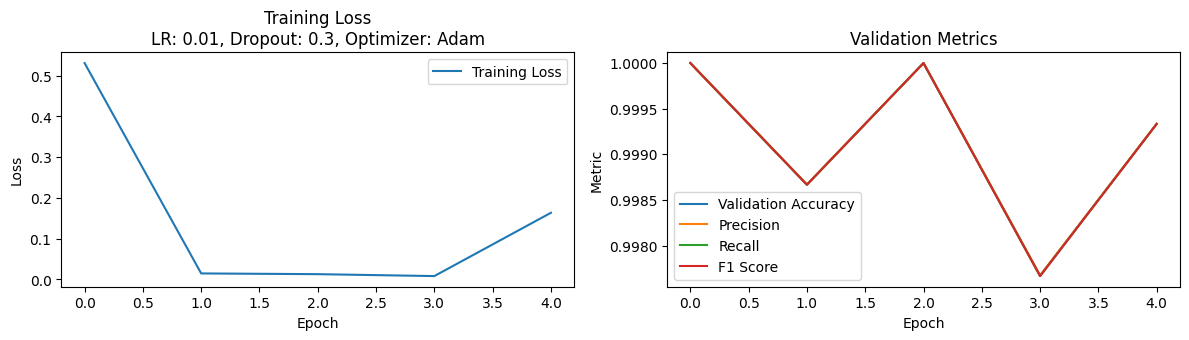

{'accuracy': [1.0, 0.9986666666666667, 1.0, 0.9976666666666667, 0.9993333333333333], 'precision': [1.0, 0.998667997338656, 1.0, 0.9976735625322563, 0.9993337494798169], 'recall': [1.0, 0.9986666666666667, 1.0, 0.9976666666666667, 0.9993333333333333], 'f1_score': [1.0, 0.9986670619353546, 1.0, 0.9976648891242033, 0.9993332706014364], 'confusion_matrix': [array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    0, 1600,    0],
       [   0,    0,    0,  800]]), array([[ 100,    0,    0,    0],
       [   0,  499,    1,    0],
       [   0,    2, 1598,    0],
       [   0,    0,    1,  799]]), array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    0, 1600,    0],
       [   0,    0,    0,  800]]), array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    1, 1599,    0],
       [   0,    0,    6,  794]]), array([[ 100,    0,    0,    0],
       [   0,  499,    1,    0],
       [   0,    0, 1599,    1],
       [ 

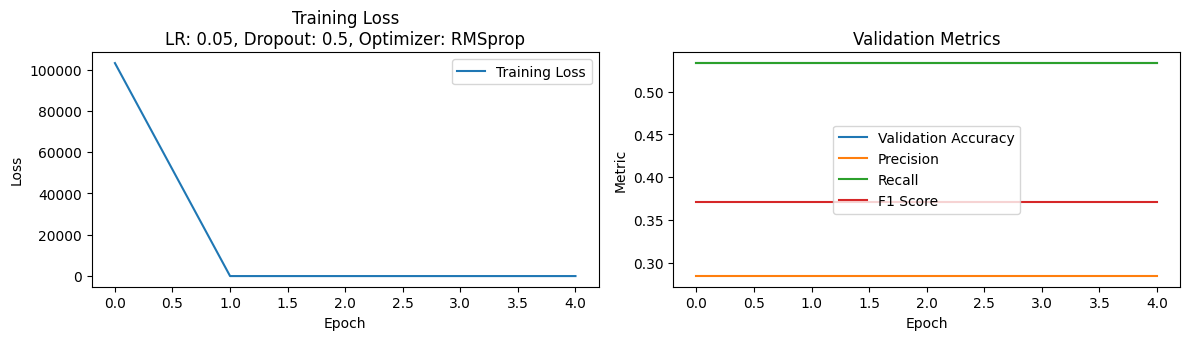

{'accuracy': [0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333], 'precision': [0.28444444444444444, 0.28444444444444444, 0.28444444444444444, 0.28444444444444444, 0.28444444444444444], 'recall': [0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333], 'f1_score': [0.3710144927536232, 0.3710144927536232, 0.3710144927536232, 0.3710144927536232, 0.3710144927536232], 'confusion_matrix': [array([[   0,    0,  100,    0],
       [   0,    0,  500,    0],
       [   0,    0, 1600,    0],
       [   0,    0,  800,    0]]), array([[   0,    0,  100,    0],
       [   0,    0,  500,    0],
       [   0,    0, 1600,    0],
       [   0,    0,  800,    0]]), array([[   0,    0,  100,    0],
       [   0,    0,  500,    0],
       [   0,    0, 1600,    0],
       [   0,    0,  800,    0]]), array([[   0,    0,  100,    0],
       [   0,    0,  500,    0],
       [   0,    0, 1600,    0],
       [   0,    

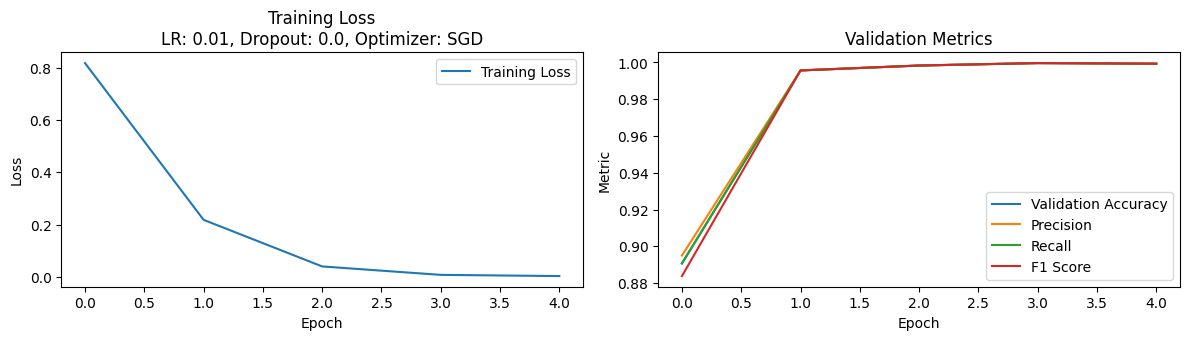

{'accuracy': [0.8906666666666667, 0.9956666666666667, 0.9983333333333333, 0.9996666666666667, 0.9993333333333333], 'precision': [0.8949681984531688, 0.9956790791339872, 0.9983388806207989, 0.999666874869873, 0.9993341656263004], 'recall': [0.8906666666666667, 0.9956666666666667, 0.9983333333333333, 0.9996666666666667, 0.9993333333333333], 'f1_score': [0.8837844704545387, 0.9956617437027746, 0.9983341511605688, 0.9996666145019174, 0.9993331243483877], 'confusion_matrix': [array([[   0,  100,    0,    0],
       [   0,  485,   11,    4],
       [   0,  208, 1388,    4],
       [   0,    1,    0,  799]]), array([[ 100,    0,    0,    0],
       [   0,  492,    8,    0],
       [   0,    2, 1598,    0],
       [   0,    0,    3,  797]]), array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    3, 1597,    0],
       [   0,    0,    2,  798]]), array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    0, 1600,    0],
       [   0,    0,    

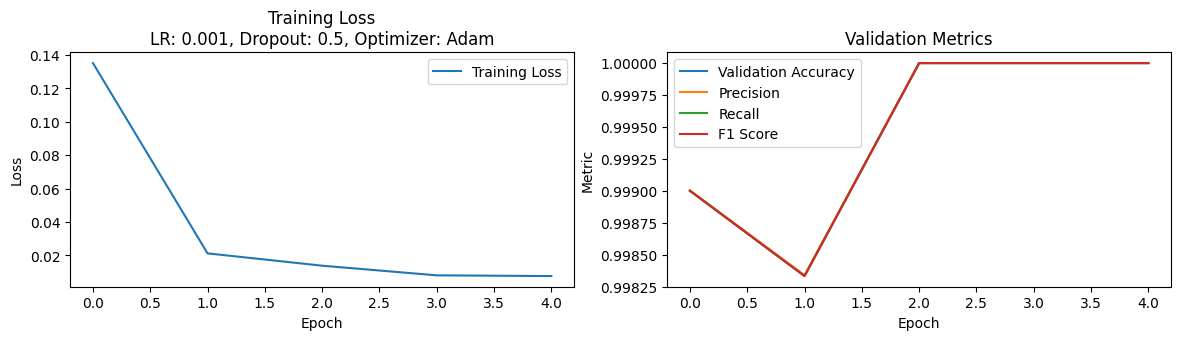

{'accuracy': [0.999, 0.9983333333333333, 1.0, 1.0, 1.0], 'precision': [0.9990023278463853, 0.9983385254413291, 1.0, 1.0, 1.0], 'recall': [0.999, 0.9983333333333333, 1.0, 1.0, 1.0], 'f1_score': [0.9990001134567845, 0.998332021055137, 1.0, 1.0, 1.0], 'confusion_matrix': [array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    1, 1597,    2],
       [   0,    0,    0,  800]]), array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    0, 1600,    0],
       [   0,    0,    5,  795]]), array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    0, 1600,    0],
       [   0,    0,    0,  800]]), array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    0, 1600,    0],
       [   0,    0,    0,  800]]), array([[ 100,    0,    0,    0],
       [   0,  500,    0,    0],
       [   0,    0, 1600,    0],
       [   0,    0,    0,  800]])], 'mae': [], 'mse': [], 'r2': []}


In [30]:
# Plot the results for each case
for result in results_copy:
    plt.figure(figsize=(12, 6))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    plt.plot(result['train_losses'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Training Loss\nLR: {result['learning_rate']}, Dropout: {result['dropout_rate']}, Optimizer: {result['optimizer']}")
    plt.legend()
    
    # convert results['val_metrics']['accuracy'] to numpy array
    # result['val_metrics']['accuracy'] = np.array(result['val_metrics']['accuracy'])


    # Plot classification metrics (adjust as needed if using regression)
    if result['val_metrics']['accuracy'] != []:
        plt.subplot(2, 2, 2)
        plt.plot(result['val_metrics']['accuracy'], label='Validation Accuracy')
        plt.plot(result['val_metrics']['precision'], label='Precision')
        plt.plot(result['val_metrics']['recall'], label='Recall')
        plt.plot(result['val_metrics']['f1_score'], label='F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()
    elif 'mae' in result['val_metrics']:
        plt.subplot(2, 2, 2)
        plt.plot(result['val_metrics']['mae'], label='MAE')
        plt.plot(result['val_metrics']['mse'], label='MSE')
        plt.plot(result['val_metrics']['r2'], label='R2 Score')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

    print(result['val_metrics'])

In [16]:
# Run the best model on test set
best_result = {'learning_rate': 0.01, 'dropout_rate': 0.3, 'optimizer': 'Adam'}
best_model = DigitCountCNN(num_classes=4, task='classification')

# train the best model
train_losses, val_metrics = train_model(
    model=best_model,
    train_loader=train_loader,
    valid_loader=val_loader,
    device=device,
    num_epochs=5,
    learning_rate=best_result['learning_rate'],
    dropout_rate=best_result['dropout_rate'],
    optimizer_name=best_result['optimizer']
)

# Evaluate on test set
y_true = []
y_pred = []

with torch.no_grad():
    if best_model.task == 'classification':
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    else:
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().view(-1, 1).to(device)
            outputs = best_model(images)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

# print all the metrics
print("Results from model")
if best_model.task == 'classification':
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")
else:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R2 Score: {r2}")

Epoch 1/5, Training Loss: 0.48808837954672485
Epoch 2/5, Training Loss: 0.027316784998875385
Epoch 3/5, Training Loss: 0.012072086167063279
Epoch 4/5, Training Loss: 0.025676478931735268
Epoch 5/5, Training Loss: 0.030733060461258874
Results from model
Accuracy: 0.9984782608695653
Precision: 0.9984835683802343
Recall: 0.9984782608695653
F1 Score: 0.9984769176683447
Confusion Matrix:
[[ 100    0    0    0]
 [   0 1500    0    0]
 [   0    0 2000    0]
 [   0    0    7  993]]


In [17]:
# run the model on test set
model.eval()
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

# print all the metrics
print("Results from model")
if model.task == 'classification':
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")
else:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R2 Score: {r2}")

Results from model
Accuracy: 0.9992391304347826
Precision: 0.9992404596304293
Recall: 0.9992391304347826
F1 Score: 0.9992387960962079
Confusion Matrix:
[[ 200    0    0    0]
 [   0 3000    0    0]
 [   0    0 4000    0]
 [   0    0    7 1993]]


In [18]:
# regression

# run for regression

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the selected cases
hyperparam_cases = [
    {'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD'},
    {'learning_rate': 0.01, 'dropout_rate': 0.3, 'optimizer': 'Adam'},
    {'learning_rate': 0.05, 'dropout_rate': 0.5, 'optimizer': 'RMSprop'},
    {'learning_rate': 0.01, 'dropout_rate': 0.0, 'optimizer': 'SGD'},
    {'learning_rate': 0.001, 'dropout_rate': 0.5, 'optimizer': 'Adam'}
]

results = []

for case in hyperparam_cases:
    # Initialize model with current dropout rate
    model = DigitCountCNN(num_classes=1, task='regression')
    model.dropout = nn.Dropout(case['dropout_rate'])

    print(f"model number {case}")
    
    # Train model and gather metrics
    train_losses, val_metrics = train_model(
        model=model,
        train_loader=train_loader,
        valid_loader=val_loader,
        device=device,
        num_epochs=5,
        learning_rate=case['learning_rate'],
        dropout_rate=case['dropout_rate'],
        optimizer_name=case['optimizer']
    )
    
    results.append({
        'learning_rate': case['learning_rate'],
        'dropout_rate': case['dropout_rate'],
        'optimizer': case['optimizer'],
        'train_losses': train_losses,
        'val_metrics': val_metrics
    })
    print(f"model number {case} done")
    print("results",results)

# save the best model
# best_model = torch.load(f"./model_classification_{case}.pt")

Using device: cuda
model number {'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD'}
Epoch 1/5, Training Loss: 0.7359033922480448
Epoch 2/5, Training Loss: 0.36467480046797524
Epoch 3/5, Training Loss: 0.18006399321147634
Epoch 4/5, Training Loss: 0.11104756963396738
Epoch 5/5, Training Loss: 0.08957996203795757
model number {'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD'} done
results [{'learning_rate': 0.001, 'dropout_rate': 0.1, 'optimizer': 'SGD', 'train_losses': [0.7359033922480448, 0.40342750740881533, 0.36467480046797524, 0.20949155611402176, 0.18006399321147634, 0.09765269543896331, 0.11104756963396738, 0.0689517866691297, 0.08957996203795757, 0.06502041892406155], 'val_metrics': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'confusion_matrix': [], 'mae': [0.44252753, 0.36137304, 0.24591194, 0.20347323, 0.19888222], 'mse': [0.40283066, 0.2091016, 0.09756205, 0.06888838, 0.064928494], 'r2': [0.28772570803409225, 0.630272218202407, 

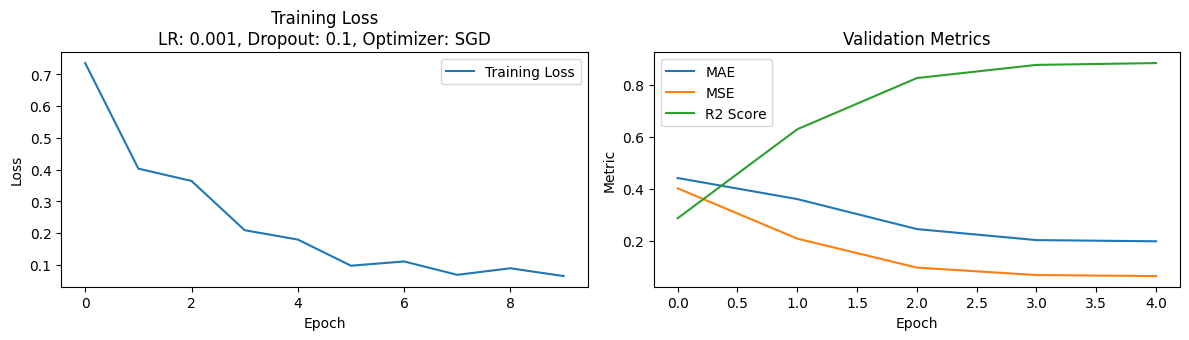

{'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'confusion_matrix': [], 'mae': [0.44252753, 0.36137304, 0.24591194, 0.20347323, 0.19888222], 'mse': [0.40283066, 0.2091016, 0.09756205, 0.06888838, 0.064928494], 'r2': [0.28772570803409225, 0.630272218202407, 0.8274934343492912, 0.8781934325544313, 0.8851951973497285]}


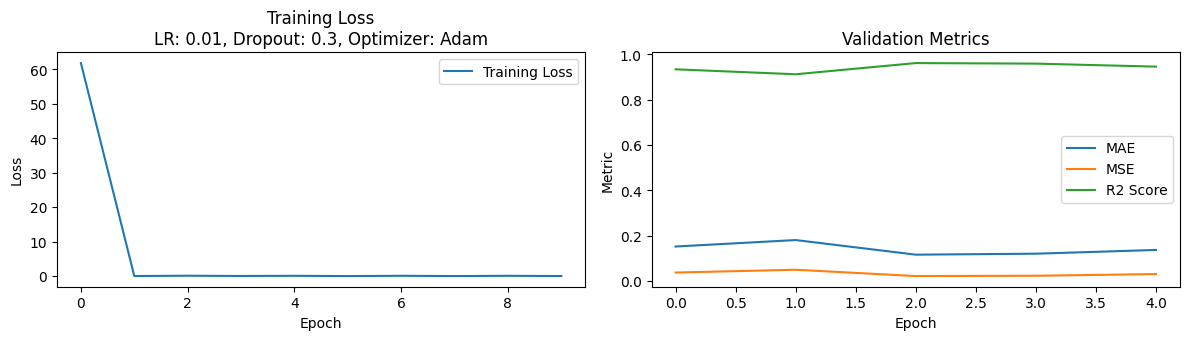

{'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'confusion_matrix': [], 'mae': [0.15217936, 0.18065764, 0.11617881, 0.120492205, 0.13701548], 'mse': [0.037326094, 0.049648788, 0.021750743, 0.023131272, 0.030603295], 'r2': [0.9340010108930641, 0.9122123596729803, 0.9615409241410612, 0.9590999121916013, 0.9458880835516639]}


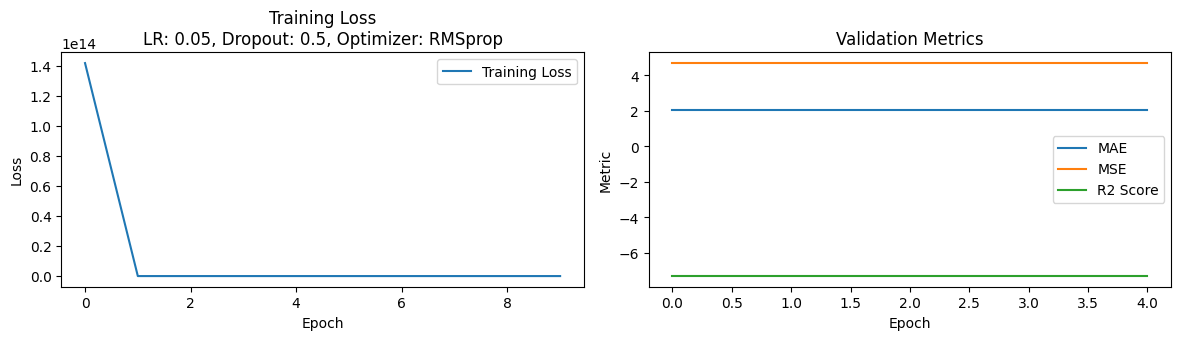

{'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'confusion_matrix': [], 'mae': [2.0333333, 2.0333333, 2.0333333, 2.0333333, 2.0333333], 'mse': [4.7, 4.7, 4.7, 4.7, 4.7], 'r2': [-7.3104125736738705, -7.3104125736738705, -7.3104125736738705, -7.3104125736738705, -7.3104125736738705]}


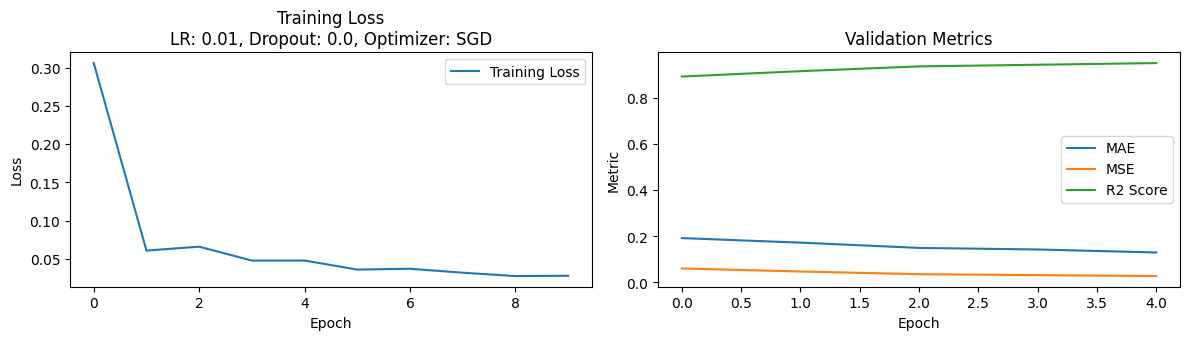

{'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'confusion_matrix': [], 'mae': [0.19227283, 0.17254935, 0.14968893, 0.14292108, 0.12991816], 'mse': [0.060551483, 0.04742192, 0.035681177, 0.031641766, 0.027567225], 'r2': [0.8929345111750738, 0.916149842958627, 0.9369095074856598, 0.9440518865658833, 0.9512563827927808]}


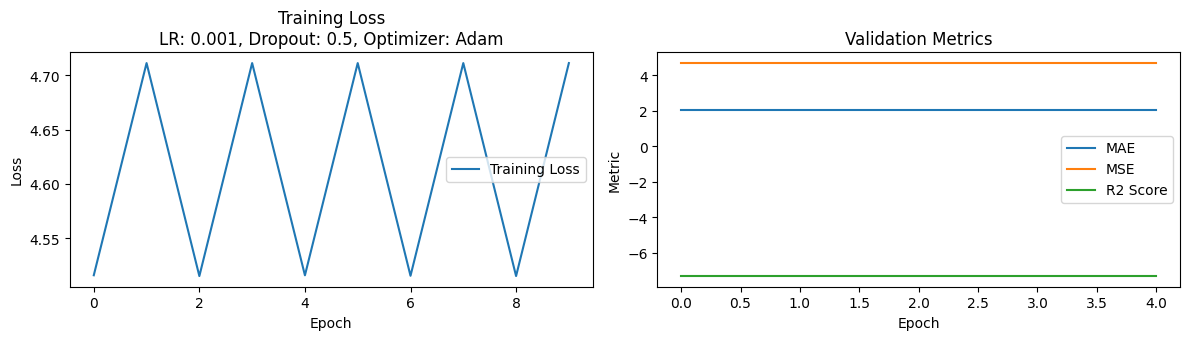

{'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'confusion_matrix': [], 'mae': [2.0333333, 2.0333333, 2.0333333, 2.0333333, 2.0333333], 'mse': [4.7, 4.7, 4.7, 4.7, 4.7], 'r2': [-7.3104125736738705, -7.3104125736738705, -7.3104125736738705, -7.3104125736738705, -7.3104125736738705]}


In [32]:
# Plot the results for each case
for result in results:
    plt.figure(figsize=(12, 6))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    plt.plot(result['train_losses'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Training Loss\nLR: {result['learning_rate']}, Dropout: {result['dropout_rate']}, Optimizer: {result['optimizer']}")
    plt.legend()
    
    if 'mae' in result['val_metrics']:
        plt.subplot(2, 2, 2)
        plt.plot(result['val_metrics']['mae'], label='MAE')
        plt.plot(result['val_metrics']['mse'], label='MSE')
        plt.plot(result['val_metrics']['r2'], label='R2 Score')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

    print(result['val_metrics'])

In [34]:
# Run the best model on test set
best_result = {'learning_rate': 0.01, 'dropout_rate': 0.3, 'optimizer': 'Adam'}
best_model = DigitCountCNN(num_classes=4, task='regression')

# train the best model
train_losses, val_metrics = train_model(
    model=best_model,
    train_loader=train_loader,
    valid_loader=val_loader,
    device=device,
    num_epochs=5,
    learning_rate=best_result['learning_rate'],
    dropout_rate=best_result['dropout_rate'],
    optimizer_name=best_result['optimizer']
)

# Evaluate on test set
y_true = []
y_pred = []

with torch.no_grad():
    if best_model.task == 'classification':
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    else:
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().view(-1, 1).to(device)
            outputs = best_model(images)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

# print all the metrics
print("Results from model")
if best_model.task == 'classification':
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")
else:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R2 Score: {r2}")
# run the model on test set
model.eval()
for images, labels in test_loader:
    images = images.to(device)
    if model.task == 'regression':
        labels = labels.float().view(-1, 1).to(device)
    else:
        labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

# print all the metrics
print("Results from model")
if model.task == 'classification':
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")
else:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R2 Score: {r2}")

Epoch 1/5, Training Loss: 121.69005788770046
Epoch 2/5, Training Loss: 0.17600220112782444
Epoch 3/5, Training Loss: 0.1706969846361482
Epoch 4/5, Training Loss: 0.1547577484950499
Epoch 5/5, Training Loss: 0.1407383252029794
Results from model
Mean Absolute Error: 0.12544900178909302
Mean Squared Error: 0.026609983295202255
R2 Score: 0.9561815379750527
Results from model


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9200,) + inhomogeneous part.

In [ ]:
# run the model on test set for regression
model.eval()
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())
    
# print all the metrics
print("Results from model")
if model.task == 'classification':
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")
else:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R2 Score: {r2}")